# Advanced Lane Detection

## Camera Calibration

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Find Corner

In [3]:
def find_corner(file_path, nx=9, ny=6, visualize = False):
    img = cv2.imread(file_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True and visualize == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure()
        plt.title(file_path)
        plt.imshow(img)
        
    return ret, corners

In [4]:
def generate_calibration_data(directory_path):
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    paths = os.path.join(directory_path, 'calibration*.jpg')
    images = glob.glob(paths)
    del images[0]
    objpoints = list()
    imgpoints = list()
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        ret, corners = find_corner(fname, visualize=False)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints

In [5]:
objpoints, imgpoints = generate_calibration_data(os.path.join(os.getcwd(), 'camera_cal'))
print('num of reference img {}'.format(len(objpoints)))
print('num of reference img {}'.format(len(imgpoints)))

num of reference img 17
num of reference img 17


### Undistorted

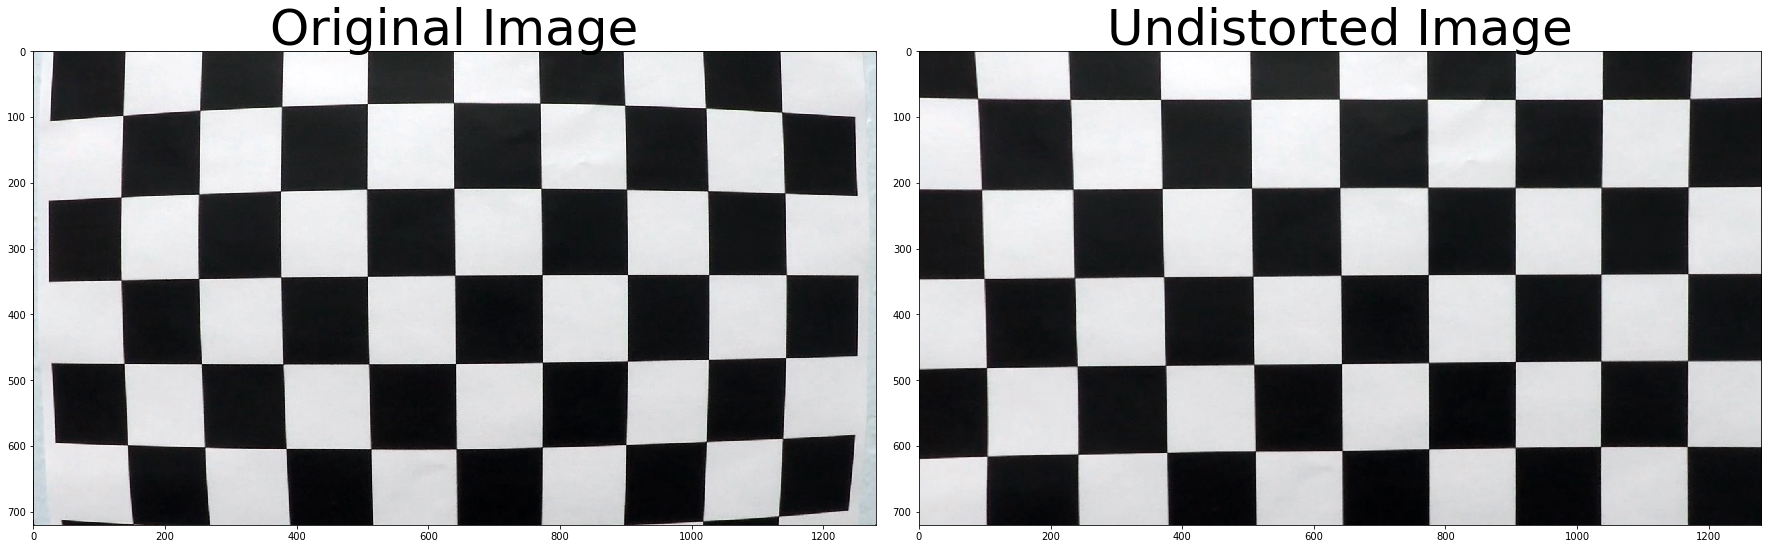

In [7]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread(os.path.join(os.getcwd(), 'camera_cal', 'calibration1.jpg'))
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

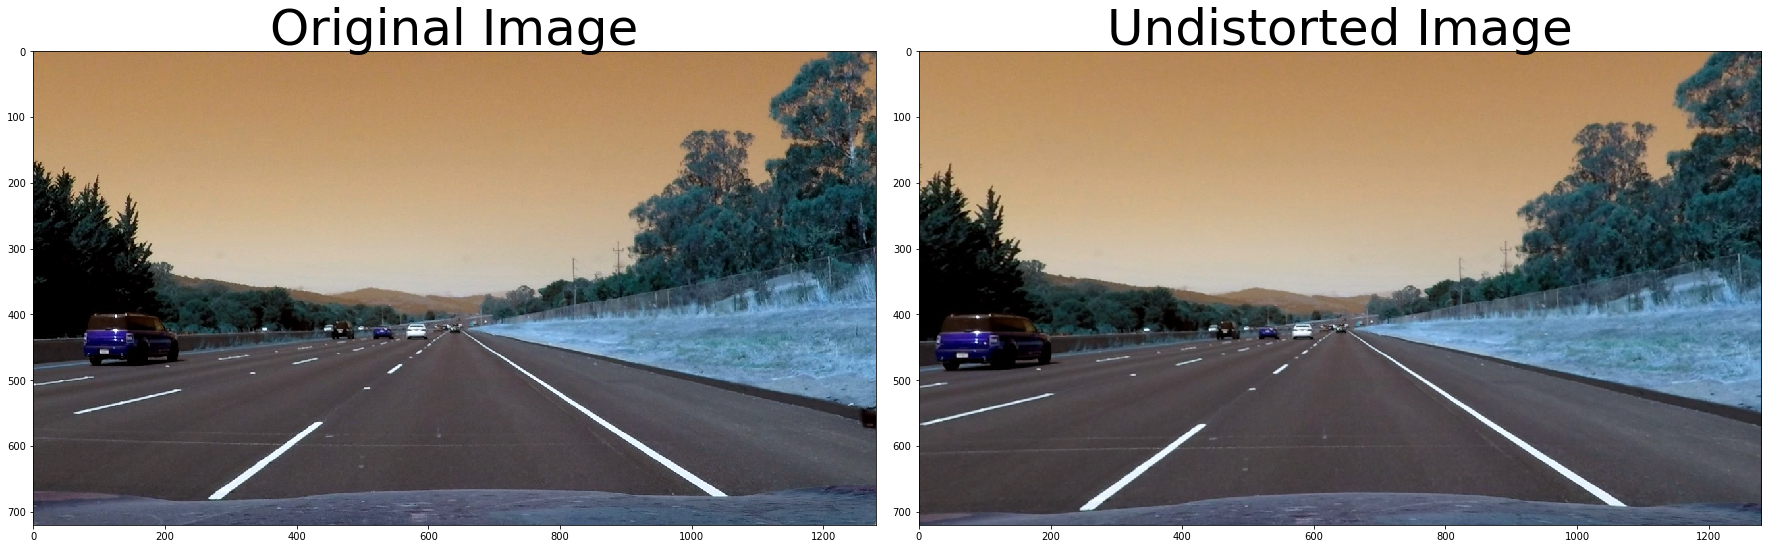

In [53]:
img = cv2.imread(os.path.join(os.getcwd(), 'test_images', 'straight_lines2.jpg'))
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholding and Binary Image

In [91]:
def thresholding(img, s_thresh=(40, 255), m_thresh=(9, 255), sx_thresh=(2, 255), angle_thresh=(-0.5, 0.5), visualize=True):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold magnitude
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude = np.uint8(255*magnitude/np.max(magnitude))
    m_binary = np.zeros_like(magnitude)
    m_binary[(magnitude >= m_thresh[0]) & (magnitude <= m_thresh[1])] = 1
    
    # Threshold direction
    angle = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    anglebinary = np.zeros_like(angle)
    anglebinary[(angle >= angle_thresh[0]) & (angle <= angle_thresh[1])] = 1
        
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined = np.zeros_like(magnitude)
    combined[(anglebinary == 1) & ((m_binary == 1) & (sxbinary == 1)) & (s_binary == 1)] = 1
    
    if visualize == True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
        f.tight_layout()

        ax1.imshow(m_binary)
        ax1.set_title('magnitude binary')

        ax2.imshow(sxbinary)
        ax2.set_title('x threshold')

        ax3.imshow(s_binary)
        ax3.set_title('s channel')

        ax4.imshow(anglebinary)
        ax4.set_title('angle')
    
    return combined

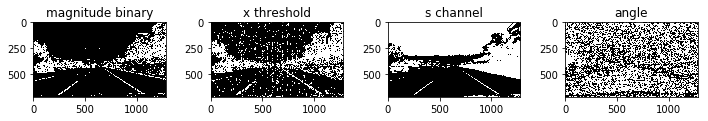

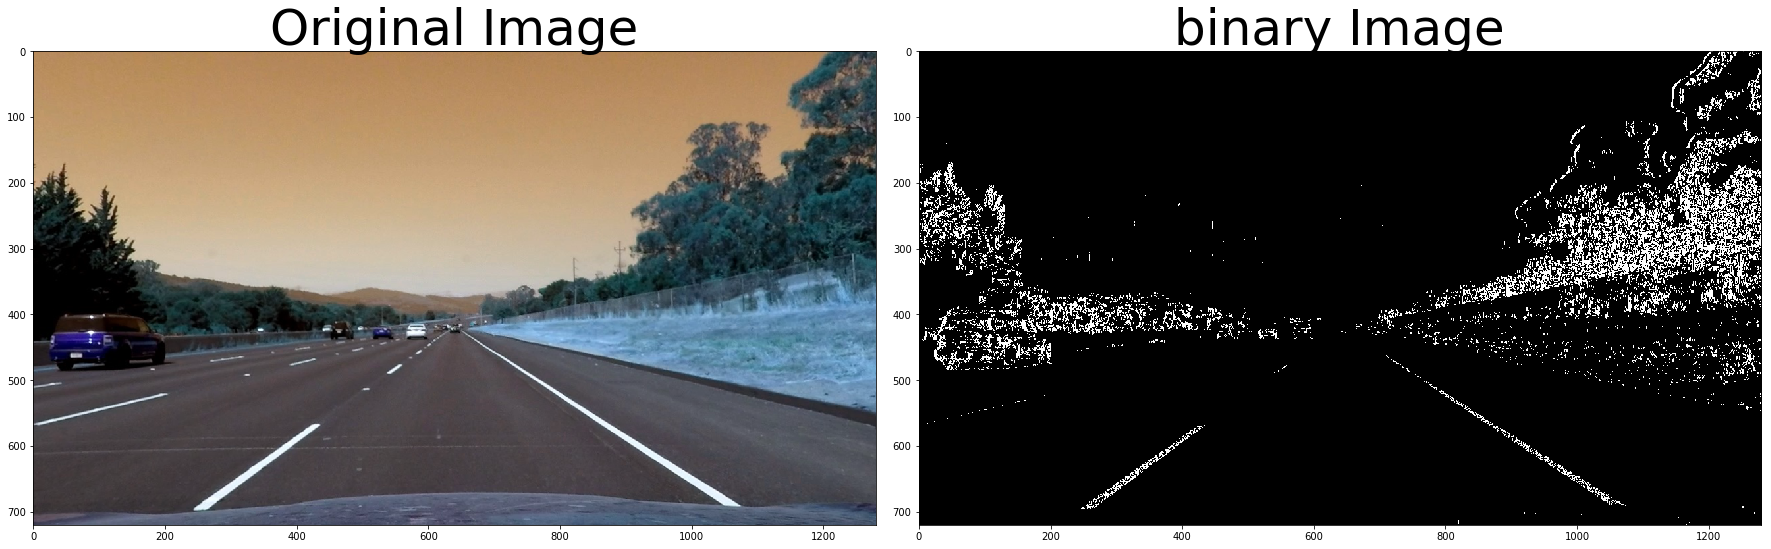

In [77]:
binary = thresholding(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary)
ax2.set_title('binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transformation

### eyeballing the interests point

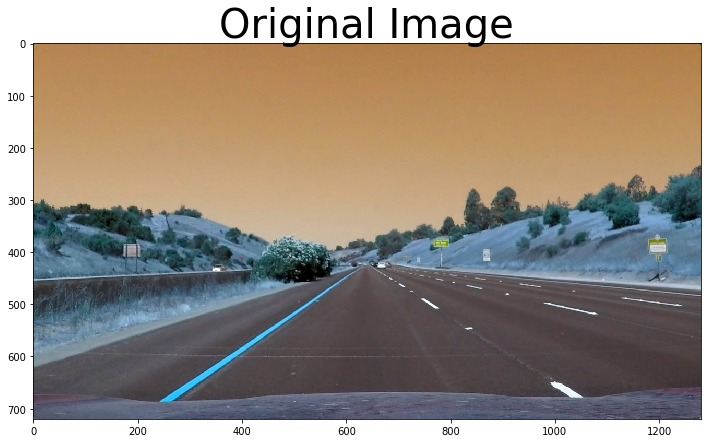

In [86]:
directory_path = os.path.join(os.getcwd(), 'test_images')
raw_image_path = os.path.join(directory_path, 'straight_lines1.jpg')
raw_image = cv2.imread(raw_image_path)

 # Plot the result
f, ax = plt.subplots()
f.tight_layout()

ax.imshow(raw_image)
ax.set_title('Original Image', fontsize=40)

In [87]:
def rectify(img):
    src = np.float32(
        [[288, 660],
         [1015, 660],
         [703, 460],
         [578, 460]])

    dst = np.float32(
        [[400, 650],
         [900, 650],
         [900, 200],
         [400, 200]])

    image_shape = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    rectified_img = cv2.warpPerspective(img, M, image_shape, flags=cv2.INTER_LINEAR)
    return rectified_img, Minv

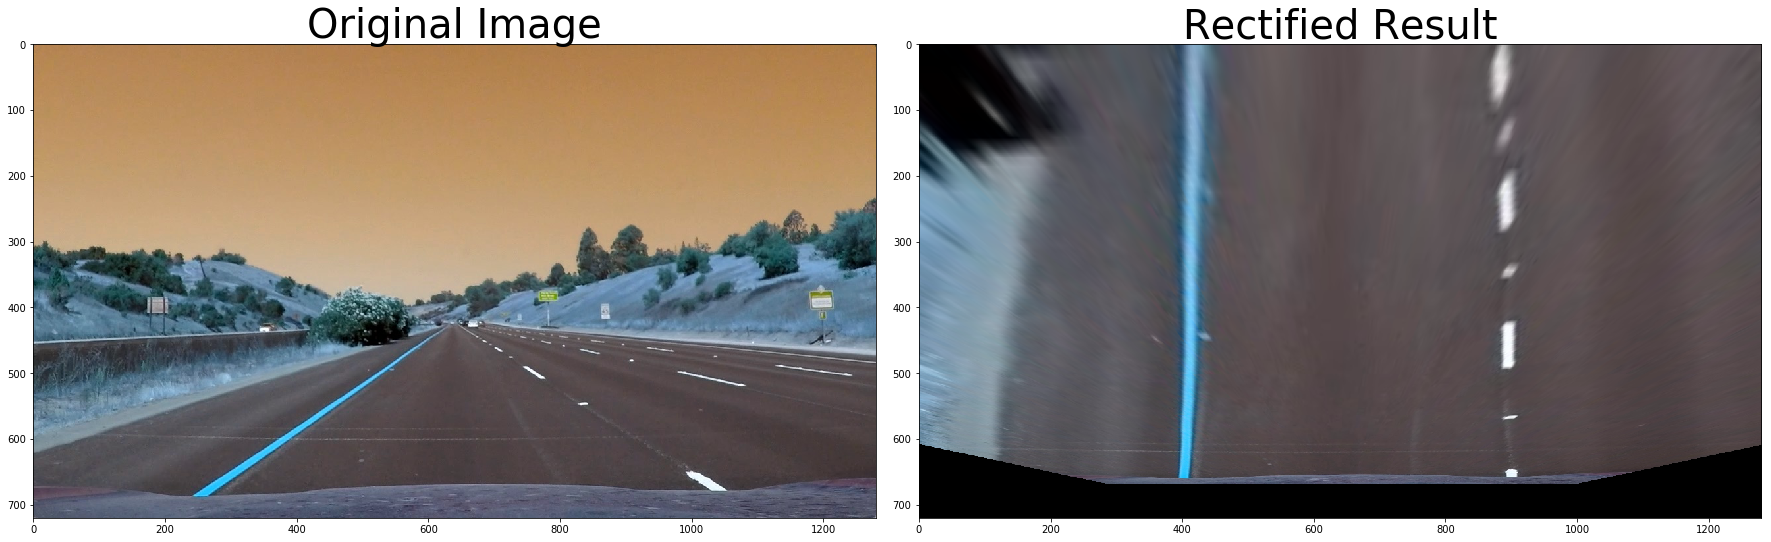

In [95]:
warped, _ = rectify(raw_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(raw_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Rectified Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

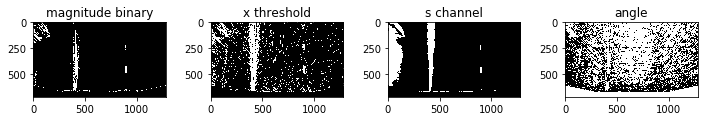

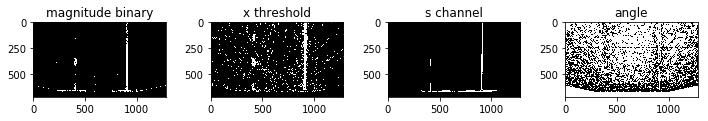

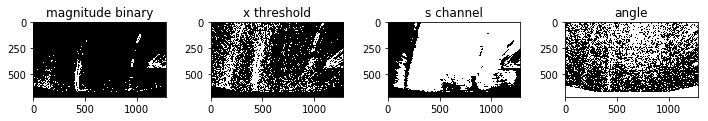

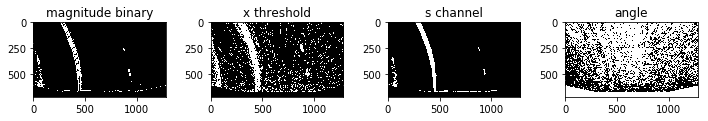

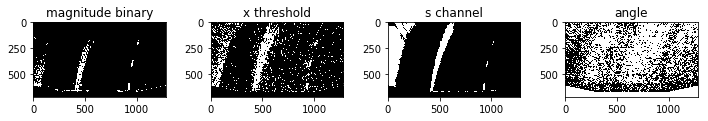

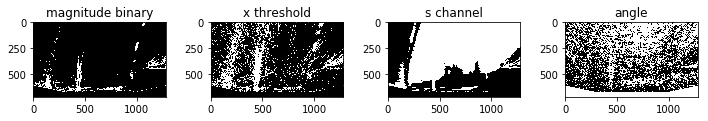

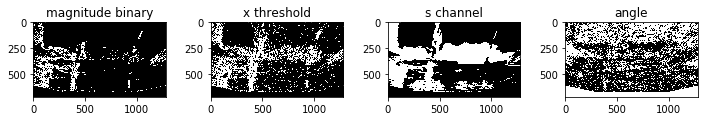

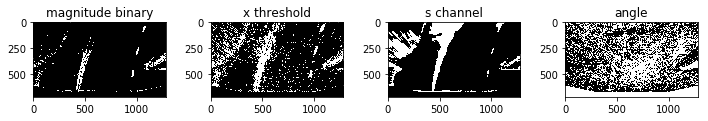

In [96]:
directory_path = os.path.join(os.getcwd(), 'test_images')
paths = os.path.join(directory_path, '*.jpg')
image_paths = glob.glob(paths)

for img_path in image_paths:
    image = cv2.imread(img_path)
    rectified_img, _ = rectify(image)
    result = thresholding(rectified_img, visualize=True)

### Apply perspective transform matrix on other images

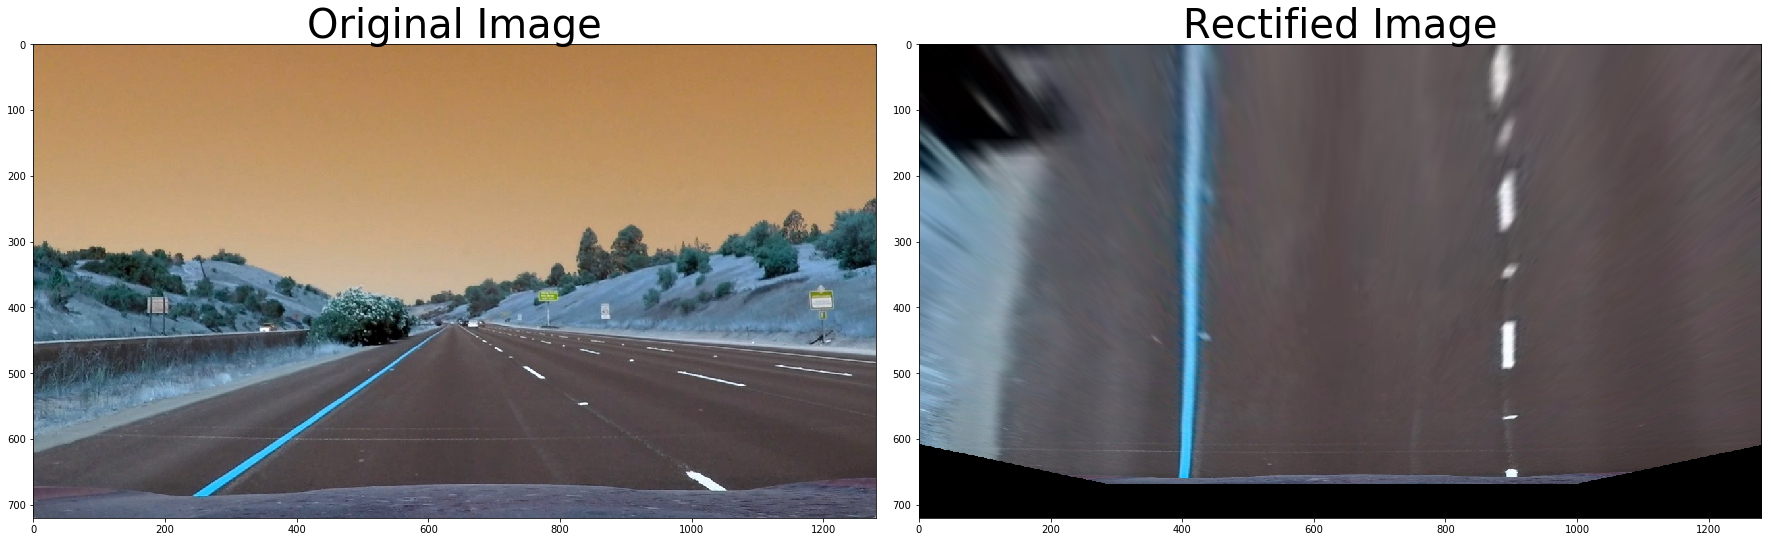

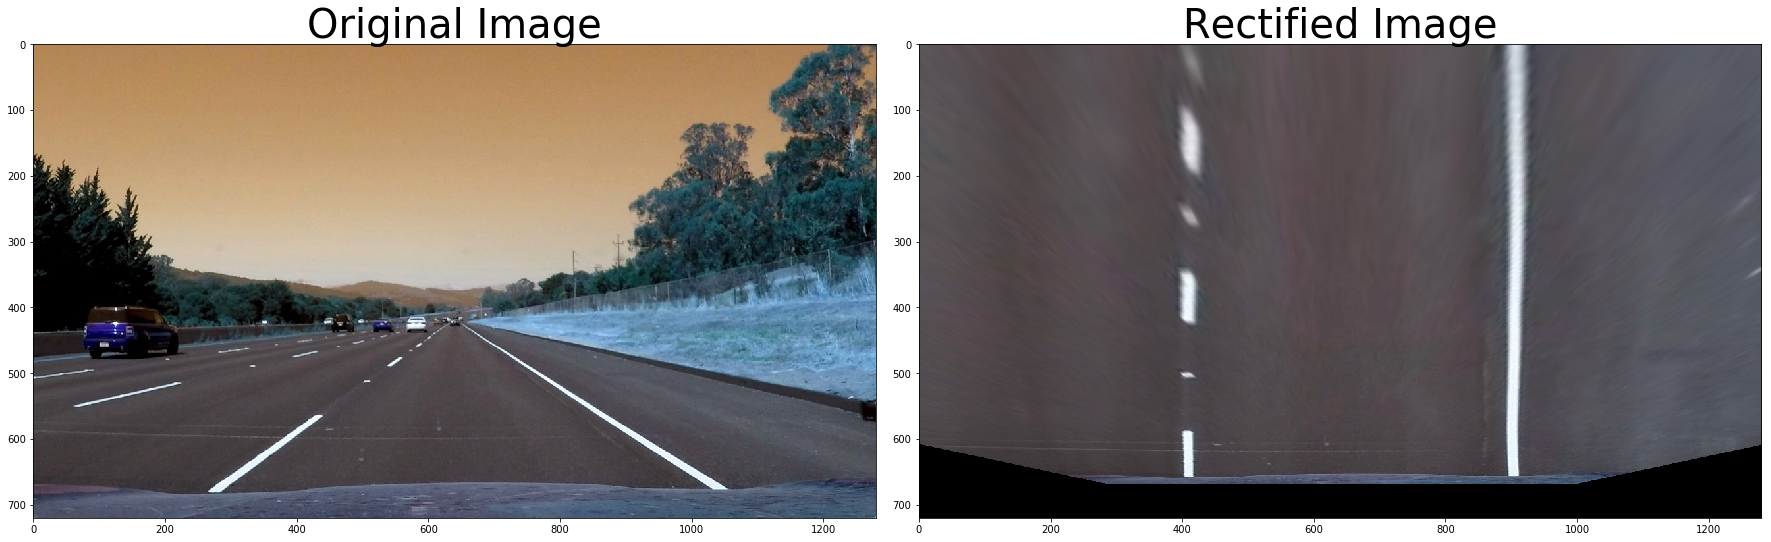

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


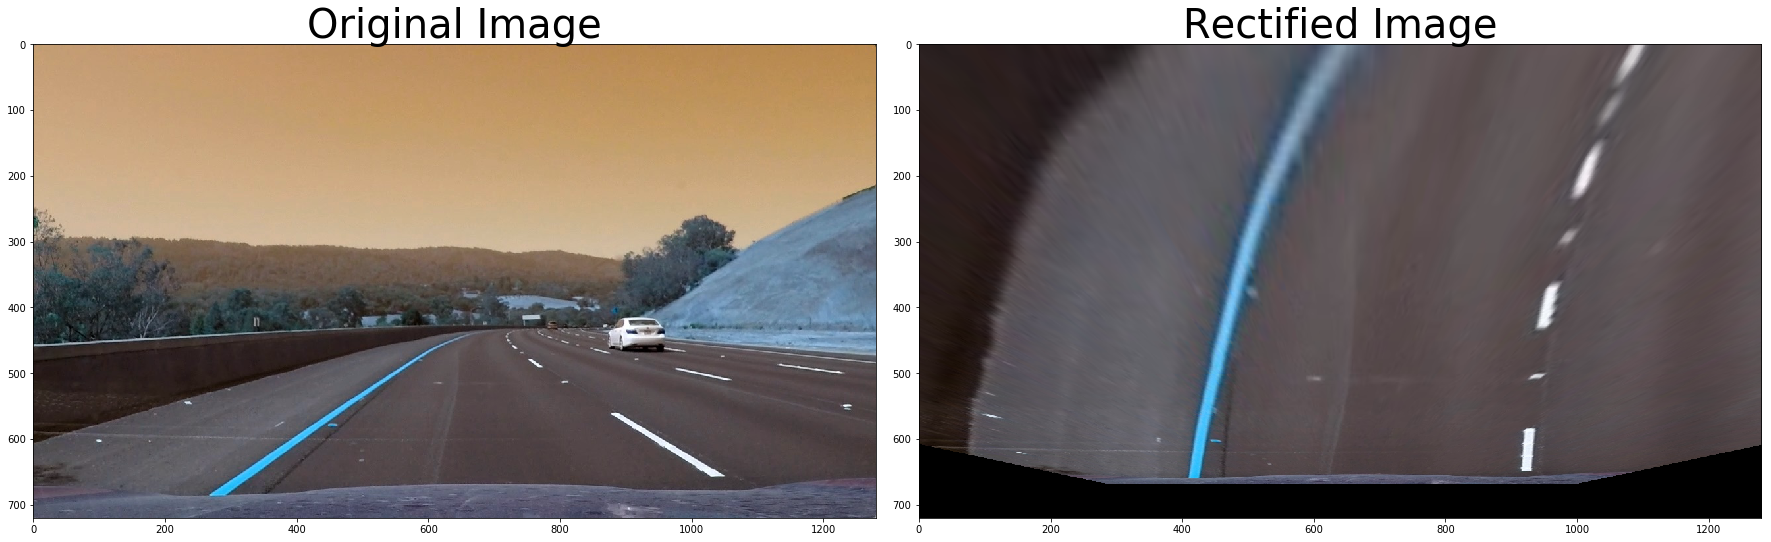

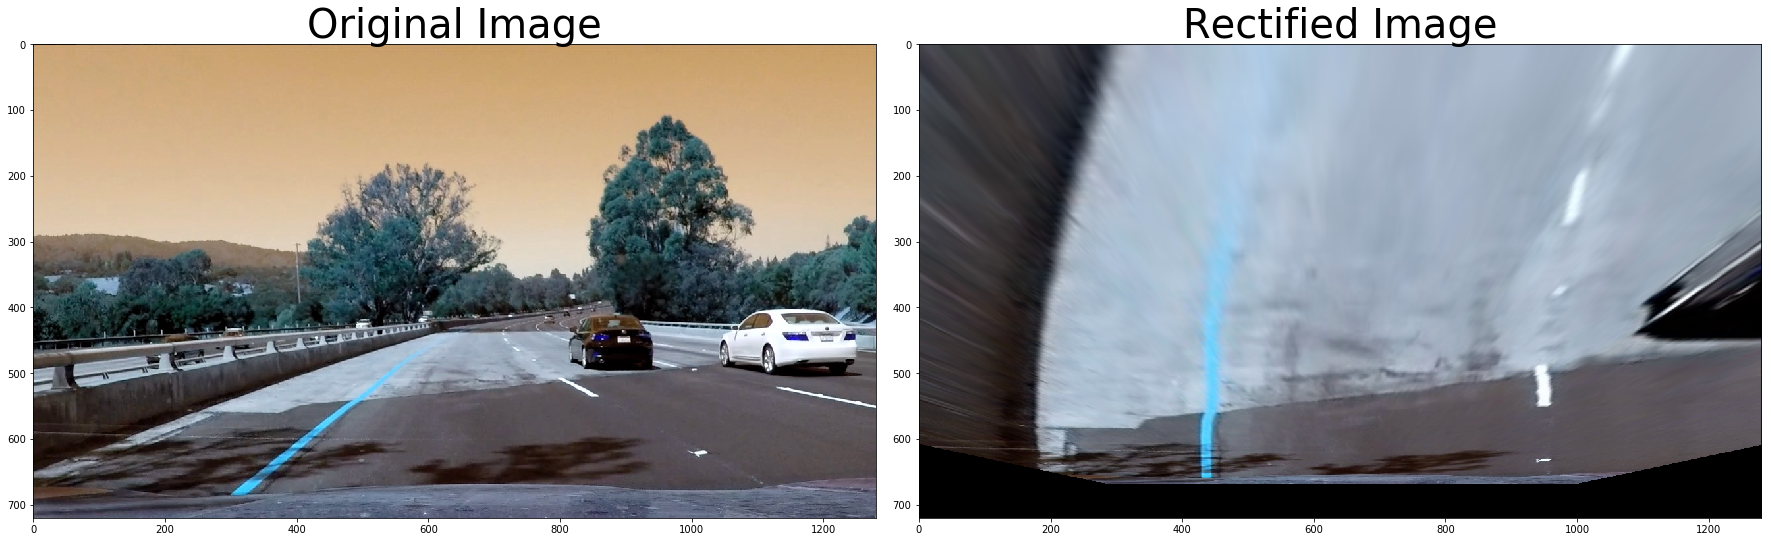

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [23]:
directory_path = os.path.join(os.getcwd(), 'test_images')
paths = os.path.join(directory_path, '*.jpg')
image_paths = glob.glob(paths)
for img_path in image_paths:
    image = cv2.imread(img_path)
    warped, _ = rectify(image)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax2.imshow(warped)
    ax2.set_title('Rectified Image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect Lane Pixel

In [92]:
def sliding_window_detector(binary_rectified, left_fit=None, right_fit=None, visualize=False):
    # Assuming you have created a warped binary image called "binary_rectified"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_rectified[int(binary_rectified.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_rectified, binary_rectified, binary_rectified))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_rectified.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_rectified.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    
    if left_fit is not None and right_fit is not None:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_rectified.shape[0]-1, binary_rectified.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_rectified.shape[0] - (window+1)*window_height
            win_y_high = binary_rectified.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)


        ploty = np.linspace(0, binary_rectified.shape[0]-1, binary_rectified.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if visualize == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        window_img = np.zeros_like(out_img)
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, left_fitx, right_fitx

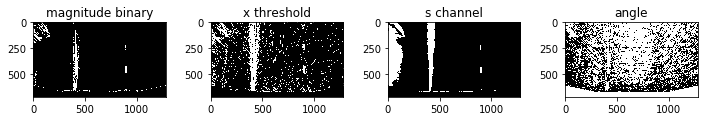

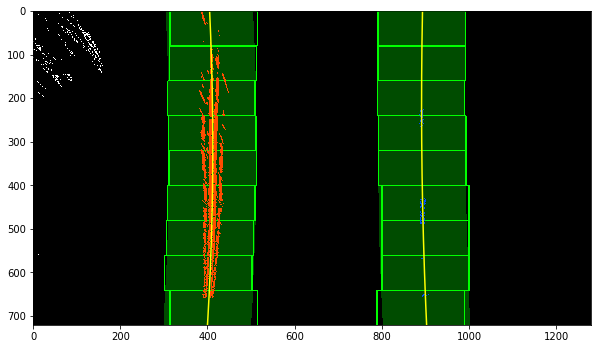

In [97]:
rectified_binary = thresholding(warped, visualize=True)
left_fit, right_fit, left_fitx, right_fitx = sliding_window_detector(rectified_binary, visualize=True)

## Determine Curvature

In [25]:
def calculate_curvature(left_fit, right_fit, rectified_binary):
    ploty =  np.linspace(0, rectified_binary.shape[0]-1, rectified_binary.shape[0])
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/50 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

## Warp Back to Original Image

In [26]:
def warp_back(undist, rectified_binary, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(rectified_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, rectified_binary.shape[0]-1, rectified_binary.shape[0])
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)  
    return result

## Pipeline

In [35]:
def pipeline(img):
    # obtain calibration points
    objpoints, imgpoints = generate_calibration_data(os.path.join(os.getcwd(), 'camera_cal'))
    undistorted_img = cal_undistort(img, objpoints, imgpoints)  
    rectified_img, Minv = rectify(undistorted_img)
    rectified_binary = thresholding(rectified_img)
    left_fit, right_fit, left_fitx, right_fitx = sliding_window_detector(rectified_binary)
    left_curverad, right_curverad = calculate_curvature(left_fit, right_fit, rectified_binary)
    result = warp_back(undistorted_img, rectified_binary, left_fitx, right_fitx, Minv)
    return result

In [ ]:
directory_path = os.path.join(os.getcwd(), 'test_images')
paths = os.path.join(directory_path, '*.jpg')
image_paths = glob.glob(paths)
for img_path in image_paths:
    image = cv2.imread(img_path)
    result = pipeline(image)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result)
    ax2.set_title('detected Image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

3099.2847264 m 5902.36967 m
5308.84484888 m 5916.29219443 m
489.484635826 m 839.307431319 m
518.299278007 m 2851.59896592 m
1231.77038404 m 698.503867271 m
968.253757181 m 1000.94209085 m
